# GC Data Collection and Elaboration

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import itertools
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xlsxwriter
import shutil
import tkinter as tk
from tkinter import filedialog

In [2]:
#Defining the JM colours
JM_colours = {
    'dark blue':(30/235,34/235,170/235), 
    'cyan':(0,172/235,233/235), 
    'teal':(157/235,211/235,203/235), 
    'pink':(229/235,0,118/235), 
    'grey':(87/235,87/235,86/235), 
    'light grey':(227/235,227/235,227/235), 
    'purple':(110/235,54/235,140/235), 
    'magenta':(229/235,0/235,118/235)
}

## Data from User
The following cell contains the data which are collected and elaborated by the user.

In [3]:
#Select the data folder

def select_folder():
    root = tk.Tk()
    root.withdraw()
    folder_path = filedialog.askdirectory()
    return folder_path

# Select the folder interactively
folder_path = select_folder()

#### GSTAT Data visualisation
To check the operating Current Density ranges before giving the input.

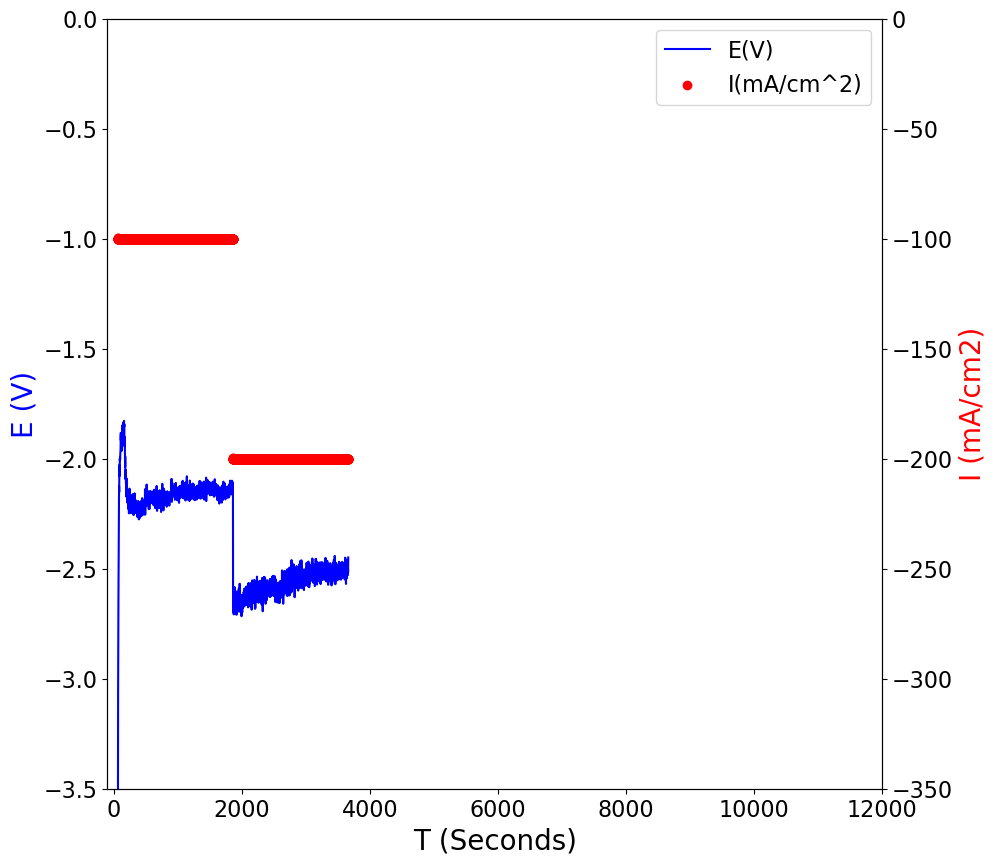

In [4]:
#Import the file
directory_path = folder_path
file_gstat = '/GSTAT_ALL.txt'
file_path = directory_path + file_gstat
gstat = pd.read_csv(file_path, delimiter='\t')

#Convert the Current 'I(A)' into 'I (mA/cm2)'
gstat['I(A/cm2)'] = gstat['I(A/cm2)'] * (1000 / 10)
gstat = gstat.rename(columns={'I(A/cm2)': 'I(mA/cm2)'})

#Extract the columns for the plot
x = gstat['T(Seconds)']
y1 = gstat['E(V)']
y2 = gstat['I(mA/cm2)']

#Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 10))

#Plot the first y-axis (E(V))
line1 = ax1.plot(x, y1, color='blue', label='E(V)')
ax1.set_xlabel('T (Seconds)', fontsize=20)
ax1.set_ylabel('E (V)', color='blue', fontsize=20)
ax1.set_ylim(-3.5, 0)
ax1.set_xlim(-100, 12000)
ax1.tick_params(axis='both', labelsize=16)

#Create a second y-axis
ax2 = ax1.twinx()

#Plot the second y-axis (I(mA/cm^2))
line2 = ax2.scatter(x, y2, color='red', label='I(mA/cm^2)')
ax2.scatter(x, y2, color='red')
ax2.set_ylabel('I (mA/cm2)', color='red', fontsize=20)
ax2.set_ylim(-350, 0)
ax2.tick_params(axis='both', labelsize=16)

#Set the legend
lines = line1 + [line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best', fontsize=16)

#Display the plot
plt.show()

Input: 
1. min current density
2. max current density
3. Step size

In [5]:
#Prompt the user for input
min_current_density = int(input("Enter the minimum current density: "))
max_current_density = int(input("Enter the maximum current density: "))
step_current_density = int(input("Enter the step size for current density: "))

#Generate the current density values based on user input
current_density_range = range(min_current_density, max_current_density-50, step_current_density)
Current_Density = [val for val in current_density_range for _ in range(2)]
#Current_Density = Current_Density.reverse()

#Print the Current_Density list
print("Current Density values:")
print(Current_Density)

Current Density values:
[-100, -100, -200, -200]


In [6]:
#From CO2 calibration curve
value_a = -257051.28935
value_b = -4313.06376

#Gases calibration curves and DataFrame creation
data = {
    'n': [2, 2, 8, 12],
    #from calibration curve y = mx + c
    'c': [814.35, 152.05, 1.1672, 102.27], 
    'm': [12739.3671, 11343, 1590.4, 1843.5],
    #Faraday constant
    'F': [96485.3329, 96485.3329, 96485.3329, 96485.3329],
    #Molar volume
    'k': [24465.3953, 24465.3953, 24465.3953, 24465.3953]
}
calibration = pd.DataFrame(data, index=['H2', 'CO', 'CH4', 'C2H4'])
calibration = calibration.transpose()
calibration

,H2,CO,CH4,C2H4
n,2.0000,2.0000,8.0000,12.0000
c,814.3500,152.0500,1.1672,102.2700
m,12739.3671,11343.0000,1590.4000,1843.5000
F,96485.3329,96485.3329,96485.3329,96485.3329
k,24465.3953,24465.3953,24465.3953,24465.3953


## Import files
The following code allows the user to import .XLS files which are named with date and time encoding. Check the `pattern` variable prior using the notebook.

In [7]:
# List all XLS files in the selected folder
files = os.listdir(folder_path)
files_xls = [f for f in files if f[-3:] == 'XLS']


#Set the file name pattern to sort the name through the code by date and time rather than sample number
pattern = r'\d{2}_\d{2}_\d{4}\s\d{2}_\d{2}_\d{2}'
filename_datetime_list = []
for filename in files_xls:
    match = re.search(pattern, filename)
    if match:
        datetime_str = match.group()
        datetime_obj = datetime.datetime.strptime(datetime_str, "%d_%m_%Y %H_%M_%S")
        filename_datetime_list.append((filename, datetime_obj))

# Sort the list of tuples based on the datetime object
sorted_filename_datetime_list = sorted(filename_datetime_list, key=lambda x: x[1])
sorted_filenames = [x[0] for x in sorted_filename_datetime_list]

#This part of the code creates a full DataFrame which contains all the data from every excel file by keeping 
#the data sorted by worksheet
dfs = []
for filename in sorted_filenames:
    dfname = pd.ExcelFile(os.path.join(folder_path, filename))
    for items in dfname.sheet_names:
        dfnew = pd.read_excel(dfname, sheet_name=items)
        dfnew['filename'] = filename  # add a new column to identify the source file
        dfs.append(dfnew)
data = pd.concat(dfs, ignore_index=True)

#This part of the script rearranges the data according to the filename and keeps only the information about the 
#second occurrance of Nitrogen, which is the one needed
a = ['Hydrogen', 'Carbon monoxide', 'Nitrogen', 'Methane', 'Ethylene']
data = data.groupby('filename',as_index=False, sort=False).apply(lambda x: x[x['Name'].isin(a)].drop_duplicates(subset='Name', keep='last'))
data = data[['Name', 'Area', 'filename']].reset_index(drop=True)

#Dealing with non-numerical data, such as N.D.=not detected from the instrument
data["Area"] = data["Area"].replace(["N.D."], 0)
data["Area"] = pd.to_numeric(data["Area"])

#Target table generation
pivot_table = data.pivot_table(index='filename', columns='Name', values='Area', sort=False)
column_order = ['Hydrogen', 'Carbon monoxide', 'Nitrogen', 'Methane',  'Ethylene']
pivot_table = pivot_table.reindex(columns=column_order)

## Data Elaboration
The following cell contains all the steps and functions to calculate the Faraday Efficiencies of the process as function of current density. Step by step:
1. The current densities are fixed by the user
2. From the CO<sub>2</sub> calibration curve it is possible to calculate the CO<sub>2</sub> flowrate
3. Calculation of partial current densities (j<sub>product</sub>):
$$
j_{product} = \frac{n * C * Q_{flow} * F}{V_m}
$$

Where _n_ is the number of transferred electrons, _C_ is the concentration of gaseous product, _Q<sub>flow</sub>_ is the volumetric flowrate (mL/min) and _V<sub>m</sub>_ is the molar volume of gas (mL/mol). The values were obtained from the standard calibration curves of each component of the product mixture.

4. Calculation of Faraday efficiencies from partial current densities divided by the total current density

In [8]:
#Add a new column to the pivot_table which contains the current densities (mAcm-2)
length_diff = len(Current_Density) - len(pivot_table)
if length_diff >= 0:
    pivot_table = pd.concat([pivot_table, pd.DataFrame(np.nan, index=np.arange(length_diff), columns=pivot_table.columns)], axis=0)
else:
    raise ValueError("Please check the number of GC files. It is higher than the current density values.")
pivot_table['Current Density (mAcm-2)'] = Current_Density

#Remove the rows which contains NaN values.
pivot_table = pivot_table.dropna()

#Rename the columns
pivot_table = pivot_table.rename(columns={'Hydrogen': 'H2', 'Carbon monoxide': 'CO', 'Nitrogen': 'N2', 'Methane': 'CH4', 'Ethylene': 'C2H4'})

#TO BE MODIFIED BY THE USER WHEN THE CO2 CALIBRATION CURVE IS REPEATED
#Add a column with a formula to obtain the CO2 flow rate (mL/min) from CO2 calibration curve (user)
pivot_table['CO2 flow rate (mL/min)'] = (pivot_table['N2'] + value_a) / value_b

#Since both 'calibration' and 'pivot_table' dataframe are based on the same chemical compounds, the following mathematical function is based on their column names
#to keep it general. N2 is not a target compound, it is just a carrier during the tests.

col_names = ['H2', 'CO', 'CH4', 'C2H4']
for col in col_names:
    pivot_table[f'J ({col}) (mAcm-2)'] = (calibration.loc['n', col]) * ((pivot_table[col] - calibration.loc['c', col]) / (calibration.loc['m', col] * 100)) * (calibration.loc['F', col] / calibration.loc['k', col]) * ((pivot_table['CO2 flow rate (mL/min)'] / 60) * (1000 / 10))

#Faraday Efficiencies (FE) are calculated by dividing the partial current densities by the total current density

cur_den_name = ['J (H2) (mAcm-2)', 'J (CO) (mAcm-2)', 'J (CH4) (mAcm-2)', 'J (C2H4) (mAcm-2)']
for col_name, col in zip(col_names, cur_den_name):
        pivot_table[f'FE ({col_name}) (%)'] = np.abs((pivot_table[col] / pivot_table['Current Density (mAcm-2)'])) * 100

#pivot_table.to_excel("GC_outputs.xlsx")
pivot_table

Name,H2,CO,N2,CH4,C2H4,Current Density (mAcm-2),CO2 flow rate (mL/min),J (H2) (mAcm-2),J (CO) (mAcm-2),J (CH4) (mAcm-2),J (C2H4) (mAcm-2),FE (H2) (%),FE (CO) (%),FE (CH4) (%),FE (C2H4) (%)
Sample1_26_05_2023 11_28_11.XLS,95932.4,87977.1,112203.2,0.0,266.9,-100,33.583572,32.963232,34.182606,-0.012960,2.365548,32.963232,34.182606,0.012960,2.365548
Sample2_26_05_2023 11_44_29.XLS,101066.6,87692.8,111991.7,1.1,250.2,-100,33.632610,34.793222,34.121703,-0.000747,2.128692,34.793222,34.121703,0.000747,2.128692
Sample3_26_05_2023 11_59_33.XLS,201404.5,145892.3,136089.0,0.0,1409.8,-200,28.045560,58.051531,47.370013,-0.010823,15.689594,29.025765,23.685007,0.005412,7.844797
Sample4_26_05_2023 12_15_10.XLS,211772.4,152958.8,98352.2,0.0,1611.3,-200,36.794979,80.098543,65.161485,-0.014200,23.756494,40.049271,32.580742,0.007100,11.878247


## Graph builder
Plot FE (%) vs J<sub>tot</sub> and create a DataFrame with the data table.

Initial Excel file saved to: C:/Users/GadolS01/OneDrive - Johnson Matthey/CATART/Python Scripts/230526 ECOF-050_Spraydried_CuO_Galvanostatic\230526 ECOF-050_Spraydried_CuO_Galvanostatic_output.xlsx
Additional Excel file copied to: C:\Users\GadolS01\OneDrive - Johnson Matthey\CATART\Python Scripts\GC_outputs\230526 ECOF-050_Spraydried_CuO_Galvanostatic_output.xlsx


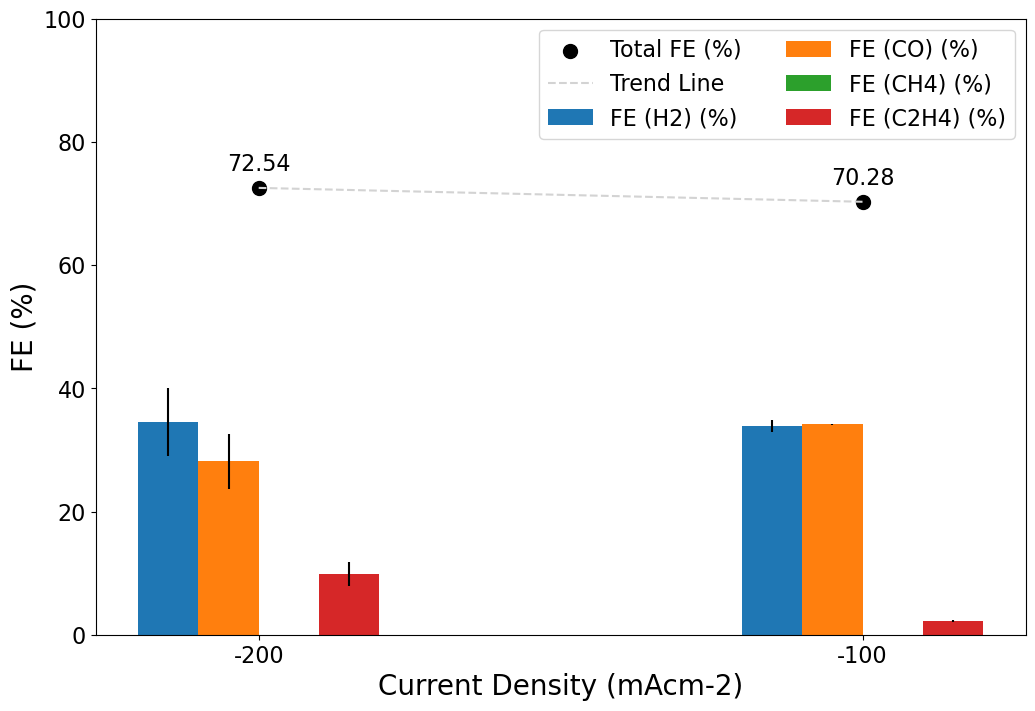

,FE (H2) (%),FE (CO) (%),FE (CH4) (%),FE (C2H4) (%),FE (H2) (%) (SE),FE (CO) (%) (SE),FE (CH4) (%) (SE),FE (C2H4) (%) (SE),Total FE (%)
Current Density (mAcm-2),,,,,,,,,
-200.00,34.537518,28.132874,0.006256,9.861522,5.511753,4.447868,0.000844,2.016725,72.538170
-100.00,33.878227,34.152155,0.006854,2.247120,0.914995,0.030451,0.006106,0.118428,70.284355


In [12]:
#For every current density's value, the following code will plot four columns related to the FEs (%) for the compounds of the final mix.
#Add the error bars calculated from standard deviation. Experimental background: the measurments are repeated twice to monitor the reproducibility and error.

#Extract the unique values of 'Current Density (mAcm-2)'
x = np.unique(pivot_table['Current Density (mAcm-2)'])

#Define the column labels
columns = ['FE (H2) (%)', 'FE (CO) (%)', 'FE (CH4) (%)', 'FE (C2H4) (%)']

#Calculate the mean and standard error for each column
mean_values = pivot_table.groupby('Current Density (mAcm-2)')[columns].apply(lambda x: x[x != 0].mean())
std_error_values = pivot_table.groupby('Current Density (mAcm-2)')[columns].apply(lambda x: x[x != 0].sem())

#Calculate the total 'FE (%)' for each 'Current Density (mAcm-2)' value
total_values = mean_values.sum(axis=1)

#Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

#Calculate the width for each group of columns
width = 10

#Plot each group of columns
for i, col in enumerate(columns):
    x_pos = x + (i - (len(columns) - 1) / 2) * width
    y = mean_values[col]
    y_err = std_error_values[col]
    ax.bar(x_pos, y, width, yerr=y_err, label=col)

#Plot the total 'FE (%)' as scatter plot markers
ax.scatter(x, total_values, s=100, marker='o', color='black', label='Total FE (%)')  #Adjust marker size and color as desired

#Fit a polynomial regression line to the total 'FE (%)' values, excluding the cases where the FE value is 0
fit_coeffs = np.polyfit(x[total_values != 0], total_values[total_values != 0], deg=1)
trend_line = np.poly1d(fit_coeffs)
ax.plot(x, trend_line(x), linestyle='--', color='lightgrey', label='Trend Line')

#Set the x and y labels
ax.set_xlabel('Current Density (mAcm-2)', fontsize=20)
ax.set_ylabel('FE (%)', fontsize=20)
ax.tick_params(axis='both', labelsize=16)

#Set the y-axis limits
ax.set_ylim(0, 100)

#Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(x)

#Set the legend position
legend=ax.legend(loc='best', fontsize=16, ncol=2)
#Set the background color of the legend
legend.get_frame().set_facecolor('white')

#Show the grid
#ax.grid(True)

#Add label to the total 'FE (%)' scatter plot
for i, j in zip(x, total_values):
    ax.text(i, j + 2, f'{j:.2f}', ha='center', va='bottom', fontsize=16)

#Concatenate mean_values and std_error_values into a single table, excluding the cases where the FE value is 0
table_data = np.concatenate((mean_values, std_error_values, total_values.to_frame(name='Total FE (%)')), axis=1)
table_data[total_values == 0] = 0  # Set the values as 0 where the FE value is 0
row_labels = [f'{val:.2f}' for val in x]
column_labels = columns + [f'{col} (SE)' for col in columns] + ['Total FE (%)']

#Create a DataFrame from the table data
table_df = pd.DataFrame(table_data, index=row_labels, columns=column_labels)

#Rename the index name to 'Current Density (mAcm-2)'
table_df = table_df.rename_axis('Current Density (mAcm-2)')

#Define the output folder where the initial Excel file will be saved
output_folder = folder_path 
folder_name = os.path.basename(output_folder)

#Set the file paths for the initial output and the additional output
output_excel_path_initial = os.path.join(output_folder, f"{folder_name}_output.xlsx")
output_excel_path_additional = r"C:\Users\GadolS01\OneDrive - Johnson Matthey\CATART\Python Scripts\GC_outputs"

#Example code to save the initial output
with pd.ExcelWriter(output_excel_path_initial, engine='xlsxwriter') as writer:
    # Write the pivot_table DataFrame to Excel
    pivot_table.to_excel(writer, sheet_name='Data Analysis')
    # Create a new worksheet for the plot
    worksheet_plot = writer.book.add_worksheet('Plot')
    # Save the plot as an image
    plt.savefig(os.path.join(output_folder, 'plot.jpeg'), bbox_inches='tight')
    # Insert the plot image into the worksheet
    worksheet_plot.insert_image('B2', os.path.join(output_folder, 'plot.jpeg'))
    # Write the table_df DataFrame to Excel
    table_df.to_excel(writer, sheet_name='FE (%)')

print(f"Initial Excel file saved to: {output_excel_path_initial}")

#Copy the initial Excel file to the additional output folder
shutil.copyfile(output_excel_path_initial, os.path.join(output_excel_path_additional, f"{folder_name}_output.xlsx"))

print(f"Additional Excel file copied to: {os.path.join(output_excel_path_additional, f'{folder_name}_output.xlsx')}")

#Show the plot
plt.show()

#Display the table
table_df


Next steps:
1. Rename the file with the following pattern {folder_name}_output.xlsx
2. Save a copy of the {folder_name}_output.xlsx in a new folder "outputs"
3. Comparison with different output files: (a) FEs sorted data; (b) stacked columns of the selected FEs at fixed current densities and group by catalyst in an interactive way.

In [ ]:
output_folder_gc = r'C:\Users\GadolS01\OneDrive - Johnson Matthey\CATART\Python Scripts\GC_outputs'
file_list = glob.glob(os.path.join(output_folder_gc, "*_output.xlsx"))

#Display the available files to the user
print("Available Files:")
for i, file in enumerate(file_list):
    print(f"{i+1}. {os.path.basename(file)}")

#Ask the user to select the files
selected_files = input("Enter the file numbers (separated by commas) you want to include: ")
selected_files = [int(num.strip()) for num in selected_files.split(",")]

#Filter the file_list based on the user's selection
file_list = [file_list[i-1] for i in selected_files]

Current_Density = [-50, -50, -100, -100, -150, -150, -200, -200, -250, -250, -300, -300]

combined_data = pd.DataFrame()
dfs = []

for file in file_list:
    filename = file
    df = pd.read_excel(filename, sheet_name="FE (%)")
    df = df.set_index("Current Density (mAcm-2)")
    df = df.reindex(Current_Density, fill_value=0)
    df["Filename"] = os.path.basename(filename)
    dfs.append(df)

combined_data = pd.concat(dfs)

In [ ]:
combined_data

In [ ]:
#Defining the JM colours
JM_colours = {'dark blue':(30/235,34/235,170/235), 'cyan':(0,172/235,233/235), 'teal':(157/235,211/235,203/235), 'pink':(229/235,0,118/235), 'grey':(87/235,87/235,86/235), 'light grey':(227/235,227/235,227/235), 'purple':(110/235,54/235,140/235), 'magenta':(229/235,0/235,118/235)}

#Define the column labels
columns = ['FE (H2) (%)', 'FE (CO) (%)', 'FE (CH4) (%)', 'FE (C2H4) (%)']

#Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

#Calculate the width for each group of columns
width = 20

#Define the colors for the columns
colors = list(JM_colours.values())[:len(columns)]

#Calculate the total number of files
num_files = len(file_list)

#Calculate the total width for all stacked bars
total_width = width / num_files

#Calculate the offset for centered bars
offset = total_width / 2

#Number of shades of black
num_shades = len(combined_data['Filename'].unique())

#Generate a range of shades of black
shades_of_black = ['#000000']
if num_shades > 1:
    #Create a gradient of shades using numpy's linspace
    grayscale = np.linspace(0, 0.9, num_shades)  #Adjust the range (0, 0.9) for different shades
    for i in range(1, num_shades):
        shade = '#%02x%02x%02x' % (int(grayscale[i]*255), int(grayscale[i]*255), int(grayscale[i]*255))
        shades_of_black.append(shade)

#Create a list to store scatter plot handles and labels
scatter_handles = []
scatter_labels = []

#Create a list to store the custom legend patches
legend_patches = []

#Plot each group of columns for each filename
for i, file in enumerate(combined_data['Filename'].unique()):
    #Extract the data for the current filename
    data = combined_data[combined_data['Filename'] == file]
    #Extract the unique values of 'Current Density (mAcm-2)'
    x = np.unique(data.index)
    #Calculate the mean and standard error for each column
    mean_values = data.groupby('Current Density (mAcm-2)')[columns].mean()
    std_error_values = data.groupby('Current Density (mAcm-2)')[columns].sem()
    #Calculate the total 'FE (%)' for each 'Current Density (mAcm-2)' value
    total_values = mean_values.sum(axis=1)
    #Calculate the x position for each group of columns
    x_pos = x - (total_width * num_files) / 2 + (i + 0.5) * total_width
    #Plot each group of columns
    bottom = None
    for j, col in enumerate(columns):
        y = mean_values[col]
        y_err = std_error_values[col]
        if bottom is None:
            bottom = np.zeros_like(x)
        ax.bar(x_pos, y, total_width, yerr=y_err, label=col, bottom=bottom, color=colors[j])
        bottom += y
    
    #Calculate the x position for the scatter plot markers (center of each group of columns)
    scatter_x_pos = x_pos
    
    #Plot the total 'FE (%)' as scatter plot markers with different colors for each filename
    scatter = ax.scatter(scatter_x_pos, total_values, s=50, marker='o', c=shades_of_black[i % num_shades], label=file)
    
    #Store the scatter plot handle and label
    scatter_handles.append(scatter)
    scatter_labels.append(file)

    #Append a patch to the legend_patches list for each column
    if i == 0:
        for j, col in enumerate(columns):
            patch = mpatches.Patch(color=colors[j], label=col)
            legend_patches.append(patch)

#Set the x and y labels
ax.set_xlabel('Current Density (mAcm-2)', fontsize=20)
ax.set_ylabel('FE (%)', fontsize=20)
ax.tick_params(axis='both', labelsize=16)

#Set the y-axis limits
ax.set_ylim(0, 100)

#Set the x-axis ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(x)

#Show the grid
ax.grid(True)

#Create a custom legend for the columns
legend = fig.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.7, 0.85), fontsize=12)
#Manually adjust the position of the legends
legend.set_bbox_to_anchor((0.15, 1.0))
#Create a separate legend for the scatter plot
scatter_legend = fig.legend(handles=scatter_handles, labels=scatter_labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, fontsize=12)
#Set the background color of the legends
legend.get_frame().set_facecolor('white')
scatter_legend.get_frame().set_facecolor('white')

#Show the plot
plt.tight_layout()
plt.show()